In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Creating delivary locations

In [195]:
def create_delivary(x,y,n):
    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append([x_loc, y_loc])

    return loc

## Visualizations

In [196]:
def primary_plot(delivary_loc, obstacles):
    delivary_loc = np.array(delivary_loc)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    # plt.legend()

In [197]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [198]:
def plot_initial_route(dp, delivary_loc, obstacles, route, title=None):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")
    if title != None:
        plt.title(title)
    # plt.show()

## Calculate DP

In [199]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [200]:
def create_route(pts, extra):
    lst = pts.copy()
    idx = 0
    k = len(lst)
    for i in range(k):
        lst.insert(idx, extra)
        idx +=2

    lst.append(extra)
    return lst

## Distance Calculate

In [201]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [202]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [203]:
from shapely.geometry import LineString, Polygon, Point

def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    if line.intersects(obstacle):
      return True

  return False

In [204]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

## Generate Intermediate Point

In [205]:
def create_polygon(points):
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    return obstacle

In [206]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, obstacle in obstacle_polygons.items():
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
        if len(intersections) > 0:
            target_obs = obstacle
            break

    # If no intersections found, return None
    if not intersections:
        return None

    # Calculate distances from each intersection to A
    distances = {}
    for inter in intersections:
        dist_to_a = math.sqrt(((inter.x - point_a[0]) ** 2) + ((inter.y - point_a[1]) ** 2))
        distances[inter] = dist_to_a

    # Choose the intersection with the smallest sum of distances to A and B
    nearest_inter = min(distances, key=distances.get)

    interval = 0.3

    while interval < 2.5:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        if not left_side.intersects(target_obs):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs_id, obs in obstacle_polygons.items():
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        if not right_side.intersects(target_obs):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs_id, obs in obstacle_polygons.items():
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        if not up_side.intersects(target_obs):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs_id, obs in obstacle_polygons.items():
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        if not down_side.intersects(target_obs):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs_id, obs in obstacle_polygons.items():
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += 0.3

    return None

In [207]:
def adv_route(route, dp, obstacles):
    for i in range(len(route)):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            intermediate_point = find_inter_point(route[i], route[i+1], obstacles)
            route.insert(i+1, intermediate_point)
            route.insert(i+3, intermediate_point)
    return route

## Creation of New DP

In [208]:
def replace(lst, pt1, pt2):
    ls2 = lst.copy()
    for i in range(len(ls2)):
        if ls2[i] == pt1:
            ls2[i] = pt2

    return ls2

In [209]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 4)
        start += step

In [210]:
def calculate_obstacle_free_dp(delivery_loc, obstacles):
    # Create Shapely objects for efficient geometric calculations
    delivery_points = [Point(x, y) for x, y in delivery_loc]
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}

    # Initialize potential DP locations (covering the delivery point area)
    min_x, max_x, min_y, max_y = float('inf'), float('-inf'), float('inf'), float('-inf')
    for point in delivery_points:
        min_x = min(min_x, point.x)
        max_x = max(max_x, point.x)
        min_y = min(min_y, point.y)
        max_y = max(max_y, point.y)

    potential_dps = []
    for x in frange(min_x, max_x, 0.5):
        for y in frange(min_y, max_y, 0.5):
            potential_dps.append([x, y])

    # Evaluate each potential DP and filter out those obstructed by obstacles
    accessible_dps = []
    for dp in potential_dps:
        dp_point = Point(*dp)
        is_reachable = True
        for obstacle_id, obstacle in obstacle_polygons.items():
            # Check if any obstacle intersects the straight line from dp to each delivery point
            for delivery_point in delivery_points:
                line = LineString([dp_point, delivery_point])
                if line.intersects(obstacle):
                    is_reachable = False
                    break
            if not is_reachable:  # Early break if obstructed by any obstacle
                break
        if is_reachable:
            accessible_dps.append(dp)

    # Choose the DP with minimum average distance to delivery points (for efficiency)
    if not accessible_dps:
        raise ValueError("No obstacle-free DP location found!")

    best_dp = accessible_dps[0]
    min_avg_distance = float('inf')
    for dp in accessible_dps:
        total_distance = 0
        for delivery_point in delivery_points:
            total_distance += euc_distance(dp, [delivery_point.x, delivery_point.y])
        avg_distance = total_distance / len(delivery_points)
        if avg_distance < min_avg_distance:
            min_avg_distance = avg_distance
            best_dp = dp

    return best_dp

## Main

In [211]:
# pre-assumptions
x = [22.21, 88.45]
y = [32.45, 98.67]
n = 10

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

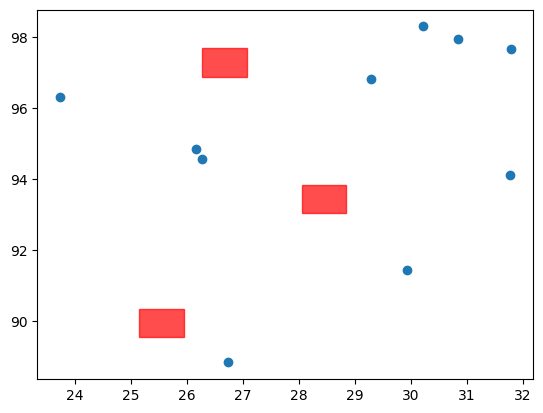

In [212]:
# creating obstacles
obstacles = {
    0 : [[28.05, 93.05],[28.85, 93.85]],
    1 : [[25.15, 89.55],[25.95, 90.35]],
    2 : [[26.27, 96.89],[27.07, 97.69]]
}

primary_plot(delivary_loc, obstacles)

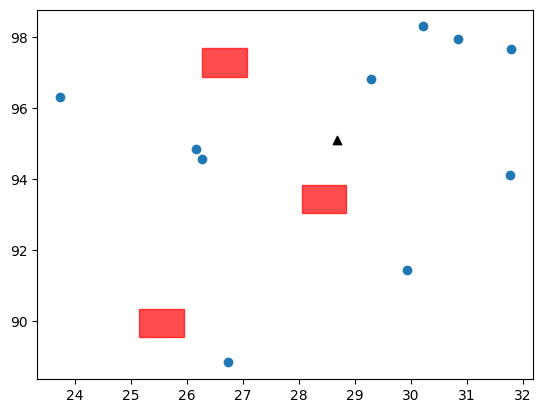

In [213]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc)

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [214]:
# calculate route
initial_route = create_route(delivary_loc,initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[28.67562170481704, 95.0963479941556] -> [29.291497918835233, 96.8369977120341] -> [28.67562170481704, 95.0963479941556] -> [31.77488087083598, 94.11512424289228] -> [28.67562170481704, 95.0963479941556] -> [31.787583067655262, 97.66924845593304] -> [28.67562170481704, 95.0963479941556] -> [23.73599195278911, 96.31904991439332] -> [28.67562170481704, 95.0963479941556] -> [30.21479184078364, 98.31080749396743] -> [28.67562170481704, 95.0963479941556] -> [29.928613759833937, 91.45471916671157] -> [28.67562170481704, 95.0963479941556] -> [26.731510412220217, 88.83562754359555] -> [28.67562170481704, 95.0963479941556] -> [30.841227199377542, 97.96790864849929] -> [28.67562170481704, 95.0963479941556] -> [26.17300768924102, 94.86743224472981] -> [28.67562170481704, 95.0963479941556] -> [26.27711233659844, 94.58656451879952] -> [28.67562170481704, 95.0963479941556] -> End


Initial Distance : 73.51265735495026


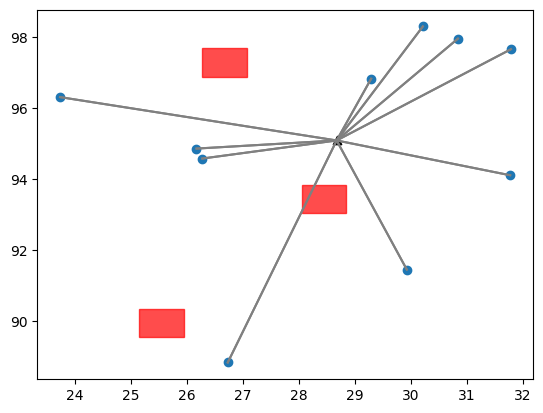

In [215]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Initial Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

--------------------------------------------------
Obstacle avoidance =>
Dp = [28.67562170481704, 95.0963479941556]
Route = [[28.67562170481704, 95.0963479941556], [29.291497918835233, 96.8369977120341], [28.67562170481704, 95.0963479941556], [31.77488087083598, 94.11512424289228], [28.67562170481704, 95.0963479941556], [31.787583067655262, 97.66924845593304], [28.67562170481704, 95.0963479941556], [23.73599195278911, 96.31904991439332], [28.67562170481704, 95.0963479941556], [30.21479184078364, 98.31080749396743], [28.67562170481704, 95.0963479941556], [29.928613759833937, 91.45471916671157], [28.67562170481704, 95.0963479941556], [27.98859927998947, 93.85], [26.731510412220217, 88.83562754359555], [27.98859927998947, 93.85], [28.67562170481704, 95.0963479941556], [30.841227199377542, 97.96790864849929], [28.67562170481704, 95.0963479941556], [26.17300768924102, 94.86743224472981], [28.67562170481704, 95.0963479941556], [26.27711233659844, 94.58656451879952], [28.67562170481704, 95.09

Relocation of DP =>
Dp = [28.236, 95.3356]
Route = [[28.236, 95.3356], [29.291497918835233, 96.8369977120341], [28.236, 95.3356], [31.77488087083598, 94.11512424289228], [28.236, 95.3356], [31.787583067655262, 97.66924845593304], [28.236, 95.3356], [23.73599195278911, 96.31904991439332], [28.236, 95.3356], [30.21479184078364, 98.31080749396743], [28.236, 95.3356], [29.928613759833937, 91.45471916671157], [28.236, 95.3356], [26.731510412220217, 88.83562754359555], [28.236, 95.3356], [30.841227199377542, 97.96790864849929], [28.236, 95.3356], [26.17300768924102, 94.86743224472981], [28.236, 95.3356], [26.27711233659844, 94.58656451879952], [28.236, 95.3356]]
Total distance = 73.65941739695974
--------------------------------------------------


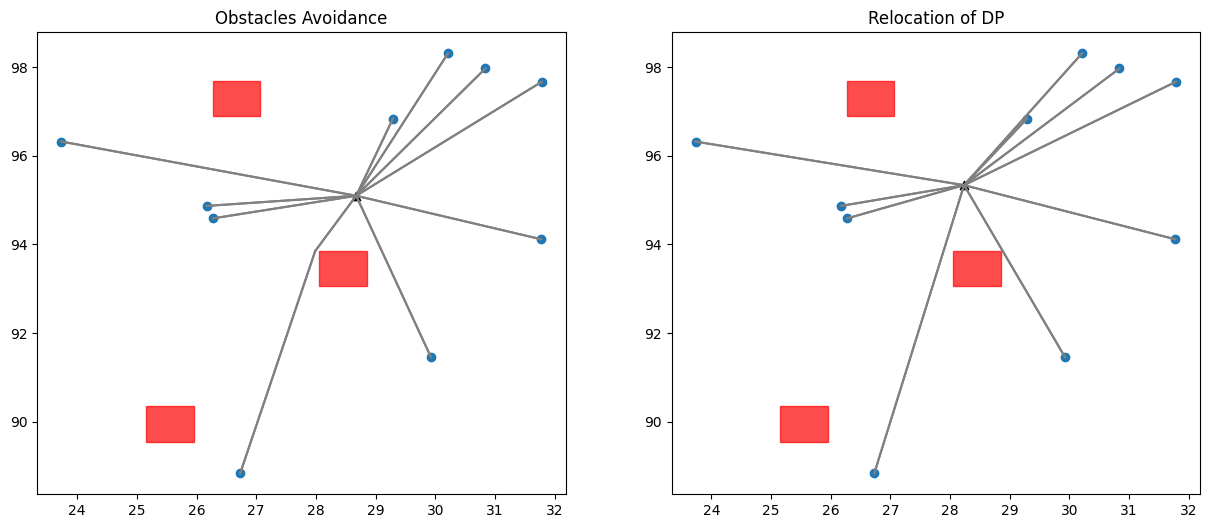

Optimal dp : [28.67562170481704, 95.0963479941556]
Optimal route : [[28.67562170481704, 95.0963479941556], [29.291497918835233, 96.8369977120341], [28.67562170481704, 95.0963479941556], [31.77488087083598, 94.11512424289228], [28.67562170481704, 95.0963479941556], [31.787583067655262, 97.66924845593304], [28.67562170481704, 95.0963479941556], [23.73599195278911, 96.31904991439332], [28.67562170481704, 95.0963479941556], [30.21479184078364, 98.31080749396743], [28.67562170481704, 95.0963479941556], [29.928613759833937, 91.45471916671157], [28.67562170481704, 95.0963479941556], [27.98859927998947, 93.85], [26.731510412220217, 88.83562754359555], [27.98859927998947, 93.85], [28.67562170481704, 95.0963479941556], [30.841227199377542, 97.96790864849929], [28.67562170481704, 95.0963479941556], [26.17300768924102, 94.86743224472981], [28.67562170481704, 95.0963479941556], [26.27711233659844, 94.58656451879952], [28.67562170481704, 95.0963479941556]]


In [216]:
THRESHOLD = initial_dist + (initial_dist*0.03)

if(detect_obstacle(initial_route, obstacles)):

    # obstacle avoidance
    temp_route = initial_route.copy()
    new_route = adv_route(temp_route, initial_dp, obstacles)
    new_dist = total_dist(new_route)
    print("-"*50)
    print("Obstacle avoidance =>")
    print("Dp =",initial_dp)
    print("Route =",new_route)
    print("Total distance =",new_dist)
    print("-"*50)

    # locate new dp
    new_dp = calculate_obstacle_free_dp(delivary_loc, obstacles)
    final_route = replace(initial_route, initial_dp, new_dp)
    final_dist = total_dist(final_route)
    print("Relocation of DP =>")
    print("Dp =",new_dp)
    print("Route =",final_route)
    print("Total distance =",final_dist)
    print("-"*50)

    # comparison
    if final_dist < new_dist:
        optimal_dp = new_dp
        optimal_route = final_route
    else:
        optimal_dp = initial_dp
        optimal_route = new_route

    # visual representation
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plot_initial_route(initial_dp,delivary_loc, obstacles, new_route, "Obstacles Avoidance")
    plt.subplot(1,2,2)
    plot_initial_route(new_dp,delivary_loc, obstacles, final_route, "Relocation of DP")
    plt.show()
else:
    optimal_dp = initial_dp
    optimal_route = initial_route

print("Optimal dp :",optimal_dp)
print("Optimal route :",optimal_route)

## Result

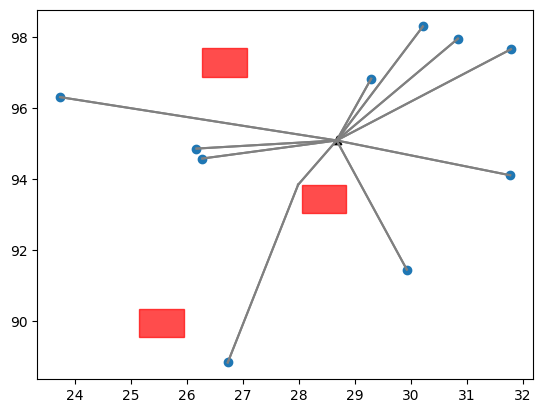

In [217]:
plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route)